<h1>Idris Tarek Elsayed Awad<h1>
<h2>The Spark Foundation<h2>
<h3>Task_4:Face Mask detection<h3>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #used for Generate more data
from tensorflow.keras.applications import MobileNetV2  #use to detect mask
from tensorflow.keras.layers import AveragePooling2D  #using in CNN
from tensorflow.keras.layers import Dropout #CNN used to drop not accurate data
from tensorflow.keras.layers import Flatten #used to convert array into one row arry
from tensorflow.keras.layers import Dense  #used hidden layer in CNN
from tensorflow.keras.layers import Input  #used for input
from tensorflow.keras.models import Model  #used for model 
from tensorflow.keras.optimizers import Adam  #used as optimizer
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input #used to make the format in rage (-1,1)
from tensorflow.keras.preprocessing.image import img_to_array #
from tensorflow.keras.preprocessing.image import load_img #used for loading data
from tensorflow.keras.utils import to_categorical  #used to covert vector to matrix
from sklearn.preprocessing import LabelBinarizer #used for Encoding data (labeling )
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [11]:
#making global vrible 
l_rate=1e-4 #.00001
epoch=20
bs=32
dir=r'./data/'
classification=['with_mask','without_mask']
print("Loading images !!!!!!!!!!")
data=[]
labels=[]
for clas in classification:
    path=os.path.join(dir,clas)
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        image=load_img(image_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        data.append(image)
        labels.append(clas)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)


Loading images !!!!!!!!!!


c:\Users\edrie\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:

print(len(labels))
print(labels[0:5])
print(labels[-5:])

2000
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [14]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [15]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))




In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=l_rate)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=8),
	steps_per_epoch=len(trainX) // 32,
	validation_data=(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=8)


[INFO] compiling model...
[INFO] training head...
Epoch 1/8
50/50 [==============================] - 17s 290ms/step - loss: 0.0518 - accuracy: 0.9850 - val_loss: 0.0404 - val_accuracy: 0.9825
Epoch 2/8
50/50 [==============================] - 14s 277ms/step - loss: 0.0701 - accuracy: 0.9825 - val_loss: 0.0283 - val_accuracy: 0.9950
Epoch 3/8
50/50 [==============================] - 13s 271ms/step - loss: 0.0657 - accuracy: 0.9775 - val_loss: 0.0407 - val_accuracy: 0.9825
Epoch 4/8
50/50 [==============================] - 16s 315ms/step - loss: 0.0421 - accuracy: 0.9825 - val_loss: 0.0576 - val_accuracy: 0.9825
Epoch 5/8
50/50 [==============================] - 14s 284ms/step - loss: 0.0271 - accuracy: 0.9875 - val_loss: 0.0315 - val_accuracy: 0.9875
Epoch 6/8
50/50 [==============================] - 15s 292ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0999 - val_accuracy: 0.9700
Epoch 7/8
50/50 [==============================] - 14s 284ms/step - loss: 0.0368 - accuracy: 0.987

In [21]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
13/13 [==============================] - 6s 424ms/step
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       200
without_mask       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

[INFO] saving mask detector model...


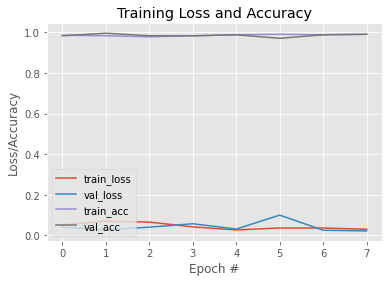

In [25]:
E=epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 8), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 8), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 8), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 8), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")